In [1]:
import os,shutil,random,re
import numpy as np
import time
import tensorflow as tf
import json
import cv2
from matplotlib import pyplot as plt
from PIL import Image
np.set_printoptions(suppress=True)

## 1. Split the train data and test data

In [2]:
def dir_setup_all_cls(path_to_data, cate_lim, all_cate):  
    '''
    Create the train and test folders: 0 + all car plate categories
    '''
    if os.path.isdir(path_to_data): shutil.rmtree(path_to_data)
    os.mkdir(path_to_data)
    os.mkdir(path_to_data+'train/')
    os.mkdir(path_to_data+'test/')
    os.mkdir(path_to_data+'train/0/')
    os.mkdir(path_to_data+'test/0/')
    for i in range(all_cate):
        os.mkdir(path_to_data+f'train/'+cate_lim[i])
        os.mkdir(path_to_data+f'test/'+cate_lim[i])

def dir_setup_all_cls_nonback(path_to_data, cate_lim, all_cate):  
    '''
    Create the train and test folders: All car plate categories
    '''
    if os.path.isdir(path_to_data): shutil.rmtree(path_to_data)
    os.mkdir(path_to_data)
    os.mkdir(path_to_data+'train/')
    os.mkdir(path_to_data+'test/')
    for i in range(all_cate):
        os.mkdir(path_to_data+f'train/'+cate_lim[i])
        os.mkdir(path_to_data+f'test/'+cate_lim[i])

In [3]:
cate_order = ['0','A3 Sportback','A4L','A5 Sportback','A6L', 'A7 Sportback', 'Q5L Sportback', 'Q7', 'RS5']
cate = cate_order[1:]

In [4]:
master_file_train = np.load('/mnt/multi-class_simu/real data/Audi/data/master_file_train_8cls.npy')
master_file_test = np.load('/mnt/multi-class_simu/real data/Audi/data/master_file_test_8cls.npy')

In [5]:
dir_setup_all_cls_nonback('/mnt/multi-class_simu/real data/Audi/data/Images_random_8cls/', cate_order[1:], len(cate_order)-1)

In [7]:
# Re-allocate the train data according to categories.
for i in range(len(master_file_train)):
    if i % 1000 == 0: _t0 = time.time()
    infor = master_file_train[i].split('\t')
    _name = infor[1]
    _cate = infor[0]
    
    shutil.copyfile(f'/mnt/multi-class_simu/real data/Audi/data/Images_all_8cls/'+_cate+'/'+_name, f'/mnt/multi-class_simu/real data/Audi/data/Images_random_8cls/train/'+_cate+'/'+_name)
        
    if i % 1000 == 0: _t1 = time.time(); print(f'pic{i}: {np.round(_t1-_t0,2)}s')   

pic0: 0.01s
pic1000: 0.0s
pic2000: 0.01s


In [8]:
# Re-allocate the test data according to categories.
for i in range(len(master_file_test)):
    if i % 1000 == 0: _t0 = time.time()
    infor = master_file_test[i].split('\t')
    _name = infor[1]
    _cate = infor[0]

    shutil.copyfile(f'/mnt/multi-class_simu/real data/Audi/data/Images_all_8cls/'+_cate+'/'+_name, f'/mnt/multi-class_simu/real data/Audi/data/Images_random_8cls/test/'+_cate+'/'+_name)
        
    if i % 1000 == 0: _t1 = time.time(); print(f'pic{i}: {np.round(_t1-_t0,2)}s')   

pic0: 0.01s


## 2. Generate sub-images

In [8]:
dir_setup_all_cls('/mnt/multi-class_simu/real data/Audi/data/signs_8cls/', cate, len(cate))

In [5]:
def predbox_gen(nbox, _imsize_x, _imsize_y, seed=0, dx=2048, dy=2048):
    '''
    Input: 
    nbox：The number of randomly generated prediction boxes； 
    _imsize_x is the length of the prediction box; _imsize_y is the width of the prediction box.
    Output:
    Array [nbox,5], where the values of 5 are in the order of [_xmin, _ymin, _xmax, _ymax, 0]
    '''
    np.random.seed(seed)
    _x0 = np.random.randint(0, dx-_imsize_x, [nbox,1]); _x1 = _x0+_imsize_x # The central point
    _y0 = np.random.randint(0, dy-_imsize_y, [nbox,1]); _y1 = _y0+_imsize_y
    predbox = np.hstack((_x0,_y0,_x1,_y1,np.zeros([nbox,1])))
    # Boundary
    predbox[predbox<0] = 0
    predbox_x = predbox[:,[0,2]]; predbox_x[predbox_x>dx] = dx
    predbox_y = predbox[:,[1,3]]; predbox_y[predbox_y>dy] = dy
    predbox[:,[0,2]] = predbox_x; predbox[:,[1,3]] = predbox_y; 
    del predbox_x, predbox_y
    return predbox

def predbox_pos_gen(_xmin,_xmax, _ymin,_ymax, nbox_pos, _imsize_x, _imsize_y, seed=0, dx=2048, dy=2048):
    '''
    Input: 
    nbox：The number of randomly generated prediction boxes； 
    _imsize_x is the length of the prediction box; _imsize_y is the width of the prediction box.
    Output:
    Array [nbox,5], where the values of 5 are in the order of [_xmin, _ymin, _xmax, _ymax, 0]
    '''
    np.random.seed(seed)
    _x_center = np.random.randint(_xmin,_xmax, [nbox_pos,1]) # The central point
    _y_center = np.random.randint(_ymin,_ymax, [nbox_pos,1]) 
    _x0 = _x_center-int(imsize_x/2); _y0 = _y_center-int(imsize_y/2)
    _x1 = _x_center+int(imsize_x/2); _y1 = _y_center+int(imsize_y/2)
    predbox = np.hstack((_x0,_y0,_x1,_y1,np.zeros([nbox_pos,1])))
    # Boundary
    predbox[predbox<0] = 0
    predbox_x = predbox[:,[0,2]]; predbox_x[predbox_x>dx] = dx
    predbox_y = predbox[:,[1,3]]; predbox_y[predbox_y>dy] = dy
    predbox[:,[0,2]] = predbox_x; predbox[:,[1,3]] = predbox_y; 
    del predbox_x, predbox_y
    return predbox

In [6]:
def calc_iou(boxes1,boxes2):
    '''
    Input: [:, (xmin, ymin, xmax, ymax)]; It can handle multiple images.
    boxes1 are the predicted boxes, and boxes2 are the ground truth boxes.
    '''
    # Calculate the top-left and bottom-right coordinates of the intersection
    lu = tf.maximum(boxes1[:,0:2],boxes2[:,0:2])  
    rd = tf.minimum(boxes1[:,2:4],boxes2[:,2:4])  
    # Calculate the area of the intersection
    intersection = tf.maximum(0,rd - lu)
    inter_area = intersection[:,0] * intersection[:,1]
    # Calculate the area of the predicted boxes boxes1
    area1 = (boxes1[:,2]-boxes1[:,0]) * (boxes1[:,3]-boxes1[:,1])
    area2 = (boxes2[:,2]-boxes2[:,0]) * (boxes2[:,3]-boxes2[:,1])
    # Calculate the area of the union
    union_area = area1 + area2 - inter_area
    # Calculate the IOU
    IOU = inter_area / union_area
    return np.array(IOU)

# Generate the sub-images.
def sample_sub_multi(mnt_dir, result_dir, op, master_file, cate, nbox, nbox_pos, imsize_x, imsize_y, seed=0, iou_thre_back=0.2, iou_thre_mid = 0.8):
    num_gts_get = 0; ID=0
    num_gts_all = np.zeros(len(master_file))
    
    for i in range(len(master_file)):
        if i % 200 == 0: t0 = time.time()
        # Find the car plate in the picture
        infor = master_file[i].split('\t')
        _img = cv2.imread(mnt_dir+op+'/'+infor[0]+'/'+infor[1], cv2.IMREAD_COLOR) 
        [dx,dy,_] = _img.shape
        _box = re.split('[\[;,;\n;\]; ]',infor[-1])
        _ymin = int(_box[5]);_ymax = int(_box[7])
        _xmin = int(_box[1]); _xmax = int(_box[3])
        _x_center = (_xmin+_xmax)/2; _y_center = (_ymin+_ymax)/2
        _cate = infor[0]
        if _cate in cate:
            _idx_cate = np.where(_cate == np.array(cate))[0][0]
            GTs = np.array([[_xmin, _ymin, _xmax, _ymax, _idx_cate ]],dtype=np.int32)
            num_gts = GTs.shape[0]
            num_gts_all[i] = num_gts
            # Generate all random bounding boxes.
            Preds = predbox_gen(nbox, imsize_x, imsize_y, i, dx, dy) 
            for j in range(GTs.shape[0]):
                [_xmin,_ymin,_xmax,_ymax,_cate1] = GTs[j]
                Preds_pos = predbox_pos_gen(_xmin,_xmax, _ymin,_ymax, nbox_pos, imsize_x, imsize_y, i, dx, dy) 
                Preds = np.vstack((Preds,Preds_pos))
            # Match them with the annotation information to generate labels.
            GTs_re = np.array(GTs.tolist()*Preds.shape[0])
            Preds_re = Preds*1
            IOU = calc_iou(Preds_re,GTs_re) 
            IOU[IOU < iou_thre_back] = 0 
            IOU = IOU.reshape([Preds.shape[0],GTs.shape[0]]) 
            idx_preds = np.where(np.max(IOU,1)>iou_thre_mid)[0] 
            idx_mids = np.where( (np.max(IOU,1)<=iou_thre_mid) * (np.max(IOU,1)>=iou_thre_back)==1 )[0] 
            idx_gts = np.argmax(IOU[idx_preds],1) 
            Preds[idx_preds,-1] = GTs[idx_gts,-1]
            Preds[idx_mids,-1] = -1 
            num_gts_get = num_gts_get + np.unique(idx_gts).shape[0]

            if np.unique(idx_gts).shape[0] == 0:
                sub = _img[int(_xmin):int(_xmax),int(_ymin):int(_ymax)]
                sub = cv2.resize(sub, (imsize_y, imsize_x))
                ID=ID+1; cv2.imwrite(result_dir+op+'/'+_cate+'/'+str(ID)+'.jpg',sub)  
            # Save the sub-images.
            np.random.seed(seed)
            for j in range(Preds.shape[0]):
                [_xmin_subgen,_ymin_subgen,_xmax_subgen,_ymax_subgen, flag] = Preds[j]
                if int(_xmin_subgen)>=0 and int(_ymin_subgen)>=0 and int(_xmax_subgen)<dx and int(_ymax_subgen)<dy:
                    sub = _img[int(_xmin_subgen):int(_xmax_subgen),int(_ymin_subgen):int(_ymax_subgen)]        
                    if flag > 0 : 
                        ID = ID + 1; cv2.imwrite(result_dir+op+'/'+_cate+'/'+str(ID)+'.jpg',sub)  
                    if flag == 0:
                        ID = ID + 1; cv2.imwrite(result_dir+op+'/0/'+str(ID)+'.jpg',sub)              
    
        if i % 200 ==0: t1 = time.time(); print(f'epoch{i}: {np.round(t1-t0,2)}s')
    print(f'Get num_gts = {num_gts_get}. All = {np.sum(num_gts_all)}')

In [11]:
# Train data
K=8
nbox = 20; nbox_pos = 5
op = 'train'
mnt_dir = '/mnt/multi-class_simu/real data/Audi/data/Images_random_8cls/' 
result_dir = '/mnt/multi-class_simu/real data/Audi/data/signs_8cls/'
imsize_x = 40; imsize_y = 100
_t0 = time.time()
sample_sub_multi(mnt_dir, result_dir, op, master_file_train, cate_order, nbox, nbox_pos, imsize_x, imsize_y)
_t1 = time.time(); print(f'{np.round(_t1-_t0,2)}s')

epoch0: 3.12s
epoch200: 0.06s
epoch400: 0.06s
epoch600: 0.07s
epoch800: 0.08s
epoch1000: 0.07s
epoch1200: 0.09s
epoch1400: 0.08s
epoch1600: 0.08s
epoch1800: 0.07s
epoch2000: 0.08s
Get num_gts = 18. All = 2047.0


num_pos_cate0 = 42723
num_pos_cate1 = 274
num_pos_cate2 = 273
num_pos_cate3 = 252
num_pos_cate4 = 273
num_pos_cate5 = 190
num_pos_cate6 = 312
num_pos_cate7 = 227
num_pos_cate8 = 248
All_num_pos = 2049.0


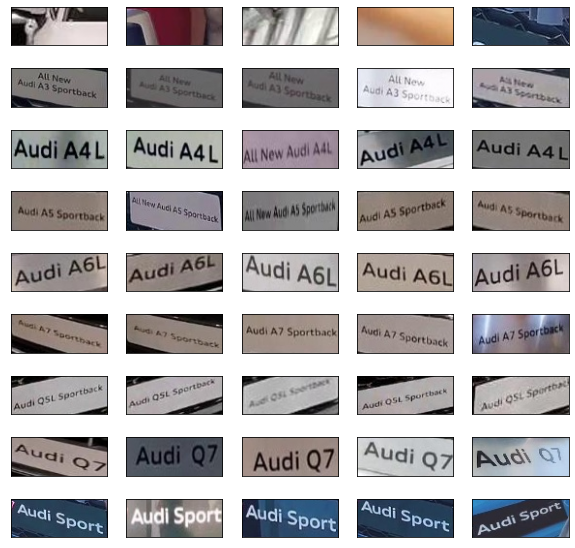

In [13]:
'''
Visualization
'''
result_dir = '/mnt/multi-class_simu/real data/Audi/data/signs_8cls/train/'
posses = []
for i in range(K+1):
    posses.append(os.listdir(result_dir+cate_order[i]+'/'))
num = np.zeros(K+1)
for i in range(K+1):
    num[i] = len(posses[i])
    print(f'num_pos_cate{i} = {len(posses[i])}')
print(f'All_num_pos = {np.sum(num[1:])}')

npic = 5
fig,ax = plt.subplots(K+1,npic)         
fig.set_figwidth(10); fig.set_figheight(10)   

for i in range(len(os.listdir(result_dir))): 
# for i in range(5): 
    for j in range(npic):
        img = np.array(Image.open(result_dir+cate_order[i]+'/'+posses[i][j]))/255
        ax[i,j].imshow(img)    
        ax[i,j].set_xticks([]); ax[i,j].set_yticks([])          
plt.show()

In [14]:
# Test data
op = 'test'
mnt_dir = '/mnt/multi-class_simu/real data/Audi/data/Images_random_8cls/' 
result_dir = '/mnt/multi-class_simu/real data/Audi/data/signs_8cls/'
imsize_x = 40; imsize_y = 100
_t0 = time.time()
sample_sub_multi(mnt_dir, result_dir, op, master_file_test, cate_order, nbox, nbox_pos, imsize_x, imsize_y)
_t1 = time.time(); print(f'{np.round(_t1-_t0,2)}s')

epoch0: 0.07s
epoch200: 0.08s
epoch400: 0.08s
Get num_gts = 0. All = 512.0


num_pos_cate0 = 10732
num_pos_cate1 = 61
num_pos_cate2 = 67
num_pos_cate3 = 63
num_pos_cate4 = 74
num_pos_cate5 = 51
num_pos_cate6 = 75
num_pos_cate7 = 62
num_pos_cate8 = 59
All_num_pos = 512.0


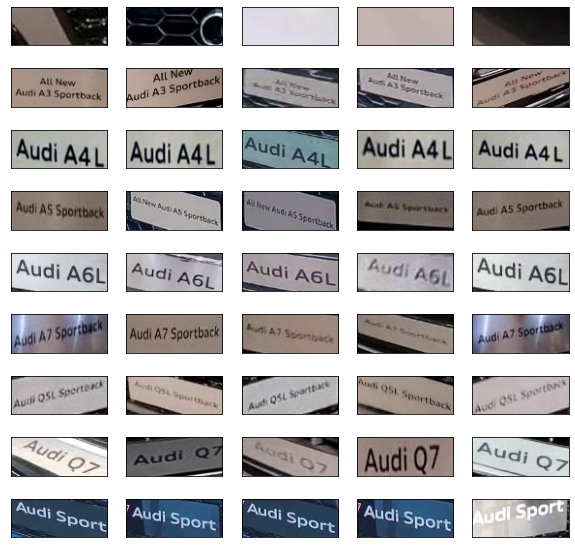

In [15]:
result_dir = '/mnt/multi-class_simu/real data/Audi/data/signs_8cls/test/'
posses = []
for i in range(K+1):
    posses.append(os.listdir(result_dir+cate_order[i]+'/'))
num = np.zeros(K+1)
for i in range(K+1):
    num[i] = len(posses[i])
    print(f'num_pos_cate{i} = {len(posses[i])}')
print(f'All_num_pos = {np.sum(num[1:])}')

'''
画图检查
'''
npic = 5
fig,ax = plt.subplots(K+1,npic) 
fig.set_figwidth(10)         
fig.set_figheight(10)         

for i in range(len(os.listdir(result_dir))): 
# for i in range(5): 
    for j in range(npic):
        img = np.array(Image.open(result_dir+cate_order[i]+'/'+posses[i][j]))/255
        ax[i,j].imshow(img)    
        ax[i,j].set_xticks([]); ax[i,j].set_yticks([])           
plt.show()

## 3. Generate features through transfer learning.

In [7]:
imsize = 64

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,AveragePooling2D,Reshape, MaxPooling2D, Flatten

base_model = VGG16(weights='imagenet', input_shape = [imsize,imsize,3], include_top = False)
x = base_model.output
x = AveragePooling2D()(x)
x = Flatten()(x)
xmodel = Model(inputs=base_model.input, outputs=x)
for layer in base_model.layers:
    layer.trainable = False
xmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [8]:
'''
Generate the high-dimensional features.
'''
def sample_to_XY(op, cate, data_dir, result_dir, imsize = 64):

    posses = []
    for k in range(len(cate)):
        posses.append(os.listdir(data_dir+op+'/'+cate[k]+'/'))
        print(f'# cls {cate[k]} = {len(posses[k])}')
    t0 = time.time()
    for k in range(len(cate)):
        for i in range(len(posses[k])):
            if i % 1000 == 0: _t0 = time.time()
            _img = Image.open(data_dir+op+'/'+cate[k]+'/'+posses[k][i]) 
            _img = _img.resize([imsize, imsize])
            X = np.zeros([1,imsize,imsize,3])
            X[0] = np.array(_img)/255
            fmap = xmodel.predict(X)
            np.save(result_dir+op+'/'+cate[k]+'/'+posses[k][i].split('.')[0]+'.npy', fmap.reshape(-1)) 
            if i % 1000 == 0: 
                _t1 = time.time()
                print('%s - cate: %d, pic:%d, %.2fs' % (op, k, i, _t1-_t0))
        
    t1 = time.time()            
    print('%s - X-Y Generation. %.2fs' % (op, t1-t0))

In [ ]:
result_dir = f'/mnt/multi-class_simu/real data/Audi/data/vecdata_512_8cls/'
dir_setup_all_cls(result_dir, cate, len(cate)) 

In [ ]:
data_dir = f'/mnt/multi-class_simu/real data/Audi/data/signs_8cls/'
op = 'train'
sample_to_XY(op, cate_order, data_dir, result_dir)

In [ ]:
op = 'test'
sample_to_XY(op, cate_order, data_dir, result_dir)

In [15]:
def sample_to_Xfeature(op, cate, data_dir, p = 2048):
    '''
    Return the number of samples in each category, the feature matrix X, and the label matrix Y
    '''
    Ns = np.zeros(len(cate))
    posses = []
    for k in range(len(cate)):
        posses.append(os.listdir(data_dir+op+'/'+cate[k]+'/'))
        Ns[k] = len(posses[k])
    X = np.zeros([int(np.sum(Ns)),p])
    Y = np.zeros([int(np.sum(Ns)),1])
    t0 = time.time()
    for k in range(len(cate)):
        for i in range(len(posses[k])):
            if i % 1000 == 0: _t0 = time.time()
            X[int(np.sum(Ns[:k])+i)] = np.load(result_dir+op+'/'+cate[k]+'/'+posses[k][i].split('.')[0]+'.npy')
            Y[int(np.sum(Ns[:k])+i)] = k
            if i % 1000 == 0: 
                _t1 = time.time()
                print('%s - cate: %d, pic:%d, %.2fs' % (op, k, i, _t1-_t0)) 
    
    t1 = time.time()            
    print('%s - X-Y Generation. %.2fs' % (op, t1-t0))
    return Ns, X, Y

In [ ]:
data_dir = f'/mnt/multi-class_simu/real data/Audi/data/vecdata_512_8cls/'
op = 'train'
Ns0, X0, Y0 = sample_to_Xfeature(op, cate_order, data_dir, 512)

In [ ]:
op = 'test'
Ns1, X1, Y1 = sample_to_Xfeature(op, cate_order, data_dir, 512)

In [18]:
Ns0, Ns1

(array([42723.,   274.,   273.,   252.,   273.,   190.,   312.,   227.,
          248.]),
 array([10732.,    61.,    67.,    63.,    74.,    51.,    75.,    62.,
           59.]))

In [19]:
np.savez('/mnt/multi-class_simu/real data/Audi/data/512_traindata_8cls.npz', X0=X0, Y0=Y0, Ns0=Ns0)
np.savez('/mnt/multi-class_simu/real data/Audi/data/512_testdata_8cls.npz', X1=X1, Y1=Y1, Ns1=Ns1)